In [87]:
# Load Vine dataset from scikit-learn

from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch


torch.manual_seed(1234)

# load dataset
data = load_wine()

df=pd.DataFrame(data["data"],columns=data["feature_names"])
y=df["alcohol"]
x=df.drop("alcohol",axis=1)

In [88]:
scaler=StandardScaler()
scaler.fit(x)
x_scaled=scaler.transform(x)

x=pd.DataFrame(x_scaled,columns=x.columns)
x.head()

,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,-0.562250,0.232053,-1.169593,1.913905,0.808997,1.034819,-0.659563,1.224884,0.251717,0.362177,1.847920,1.013009
1,-0.499413,-0.827996,-2.490847,0.018145,0.568648,0.733629,-0.820719,-0.544721,-0.293321,0.406051,1.113449,0.965242
2,0.021231,1.109334,-0.268738,0.088358,0.808997,1.215533,-0.498407,2.135968,0.269020,0.318304,0.788587,1.395148
3,-0.346811,0.487926,-0.809251,0.930918,2.491446,1.466525,-0.981875,1.032155,1.186068,-0.427544,1.184071,2.334574
4,0.227694,1.840403,0.451946,1.281985,0.808997,0.663351,0.226796,0.401404,-0.319276,0.362177,0.449601,-0.037874


In [89]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=1234)
x_train_tensor=torch.tensor(x_train.values, dtype=torch.float32)

In [90]:
X.shape, y.shape

((178, 12), (178,))

# Netzarchitektur
Ein paar Gedanken zur Architektur

* shape von x: 178, 12 --> 178 rows und 12 colums
* Wieviele Input-Neurinen bracuhen wir? --> 12
* Wieviele Output-Neuronen brauchen wir? --> 1

Hiddenlayer je nach Geschmack. z.N. ein Hiddenlayer mit 30 Neuronen

## w1

Welches shape braucht w1?
w1 geht von 12 Neuronen auf 30 Neuronen, d.h. w1 braucht den shape (12, 30)

In [91]:
w1=torch.normal(std=1, mean=0, size=(12, 30), dtype=torch.float32, requires_grad=True)

## w2
Welches shape braucht 2? w2 geht von 30 Neuronen auf 1 Neuron --> shape (30, 1)

In [92]:
w2=torch.normal(std=1, mean=0, size=(30, 1), dtype=torch.float32, requires_grad=True)

# Neural Network

In [93]:
def relu(x):
    return torch.max(torch.tensor(0.0), x)

def root_mean_squared_error(y_hat,y):
    return torch.sqrt(torch.mean((y_hat-y)**2))

def get_batch(x,y,batch_size):
    for i in range(0,len(x),batch_size):
        # yield: return a generator
        yield x[i:i+batch_size],y[i:i+batch_size]

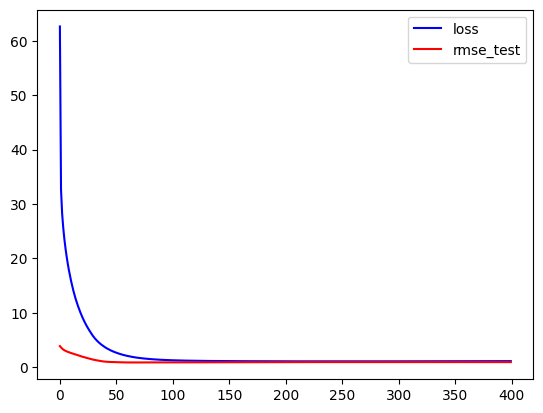

In [94]:
lr=0.01
wd=0.1
batch_size=10
torch.manual_seed(1234)

epochs=400
losses=[]
rmse_test=[]
hidden_count=20
w1 = torch.normal(std=1, mean=0, size=(12, hidden_count), dtype=torch.float32, requires_grad=True)
w2 = torch.normal(std=1, mean=0, size=(hidden_count, 1), dtype=torch.float32, requires_grad=True)
b1=torch.zeros(hidden_count, requires_grad=True)
y_train_tensor=torch.tensor(y_train.values, dtype=torch.float32)
x_test_tensor=torch.tensor(x_test.values, dtype=torch.float32)
y_test_tensor=torch.tensor(y_test.values, dtype=torch.float32)
for i in range(epochs):
    losses_in_epoch=[]
    # trainiere jeweils mit einer kleinen Auswahl an Daten, der Batch
    # xb: ist die Auswahl der Daten für die Inputneuronen
    # yb: ist die Auswahl der Daten für die Outputneuronen
    for xb,yb in get_batch(x_train_tensor,y_train_tensor,batch_size):
        y_hat=relu(relu(xb@w1+b1)@w2)
        loss=torch.mean((yb-y_hat)**2)+(torch.sum(w1**2)+torch.sum(w2**2))*wd
        losses_in_epoch.append(loss.item())
        loss.backward()
        with torch.no_grad():
            w1.sub_(lr*w1.grad)
            w2.sub_(lr*w2.grad)
            b1.sub_(lr*b1.grad)
            w1.grad.zero_()
            w2.grad.zero_()
            b1.grad.zero_()
    losses.append(sum(losses_in_epoch)/len(losses_in_epoch))
    y_test_hat=relu(relu(x_test_tensor@w1+b1)@w2)
    y_test_rmse=root_mean_squared_error(y_test_hat, y_test_tensor)
    rmse_test.append(y_test_rmse.item())

plt.plot(range(epochs),losses, color="blue")
plt.plot(range(epochs),rmse_test, color="red")
plt.legend(["loss", "rmse_test"])
plt.show()

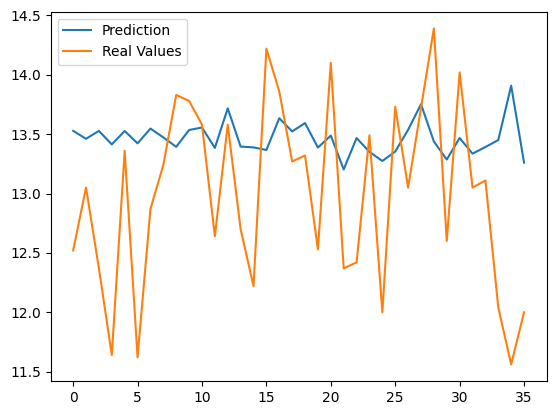

In [95]:
# Testen des Netzes
x_test_tensor = torch.tensor(x_test.values, dtype=torch.float)

prediction_items = []

for i in range(len(x_test_tensor)):
    z2 = x_test_tensor[i]@w1+b1
    a2 = relu(z2)
    z3 = a2@w2
    y_hat = relu(z3)
    prediction_items.append(y_hat.item())

# Plot Prediction and Real Values
plt.plot(prediction_items, label="Prediction")
plt.plot(y_test.values, label="Real Values")
plt.legend()
plt.show()



In [96]:
y_test_hat=relu(relu(x_test_tensor@w1+b1)@w2)
rmse_test=root_mean_squared_error(y_test_hat, y_test_tensor)
rmse_test.item()

0.9129441976547241

In [97]:
y_train_hat=relu(relu(x_train_tensor@w1+b1)@w2)
rmse_train=root_mean_squared_error(y_train_hat, y_train_tensor)
rmse_train.item()

0.9529110789299011

In [98]:
y_test_hat

tensor([[13.5279],
        [13.4608],
        [13.5272],
        [13.4136],
        [13.5263],
        [13.4226],
        [13.5469],
        [13.4727],
        [13.3930],
        [13.5349],
        [13.5559],
        [13.3841],
        [13.7172],
        [13.3952],
        [13.3885],
        [13.3665],
        [13.6340],
        [13.5229],
        [13.5932],
        [13.3870],
        [13.4879],
        [13.2026],
        [13.4672],
        [13.3508],
        [13.2739],
        [13.3533],
        [13.5365],
        [13.7522],
        [13.4381],
        [13.2864],
        [13.4674],
        [13.3356],
        [13.3916],
        [13.4504],
        [13.9082],
        [13.2599]], grad_fn=<MaximumBackward0>)